# Intro

This is a notebook summarizing experiments run in Summer 2024 by Nick Huang investigating the various use cases and performance of Prediction Powered Inference (PPI).

The equation for PPI variance, which is a key focus is given by 
\begin{equation}
    \sqrt{\frac{\hat{\sigma}_{f - \hat{Y}}}{n} + \frac{\hat{\sigma}_{F}}{N}} 
\end{equation}

Recall that the variance of the classical estimator is given by

\begin{equation}
    \sqrt{\frac{\hat{\sigma}_{\hat{Y}}}{n}}
\end{equation}

## Experiment 1

The point of experiment 1 is to be a baseline experiment of when PPI performs well. We have 3 distributions: the training distribution, the labelled (gold) distribution, and the unlabelled (ppi) distribution. In this experiment, we set all 3 distributions to be the same, and we also observe what happens when the data becomes noisier and noisier. As well, we compare what happens when we use a good/bad model, and how PPI performs compared to just classical confidence interval generation.

### Setting 1

Here we have a very idealized experiment, $X \sim Gamma(2, 2)$, and $Y = 4X + \varepsilon$. Here $\varepsilon \sim N(0, m^2 * \alpha * \beta * \frac{1 - \rho}{\rho})$, in this case, $m = 4, \alpha = 2, \beta = 2$, and $\rho$ is varied so that $Corr(X, Y) = \rho$.

We fit a linear regression model, in this scenario we expect PPI to permform very well, and should be a big improvement over classical methods.

In the following example, we set $n = 128, 16, N = 10000$, in which case, the second term in $(1)$ is irrelevant.

In [1]:
# Imports

import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import ppi
import ppi_py
import scipy.stats as stats
import pandas as pd
import ml_models as ml
import distributions as dist

import yaml
import os
import sys
import argparse
import plotting
import copy

c:\Users\Ziyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As an example, we will show what happens when $\rho = 0.5$, and fit a linear regression model to see how well the model performs. 

In [11]:
# Load file

config = "../configs/Experiment_1/reg_lin_128.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)

def test(config):
    rho_vals = [.5]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        x_gold, y_gold = dist.sample_population(pop_config)

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

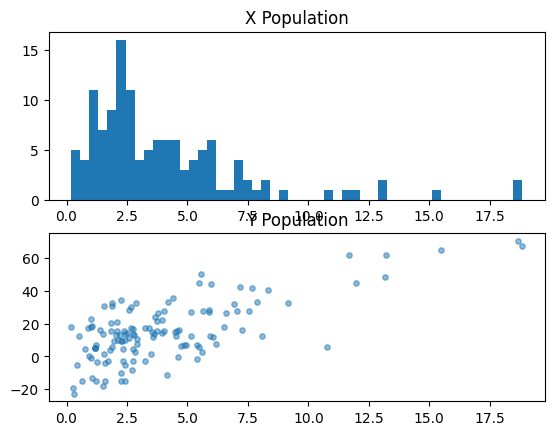

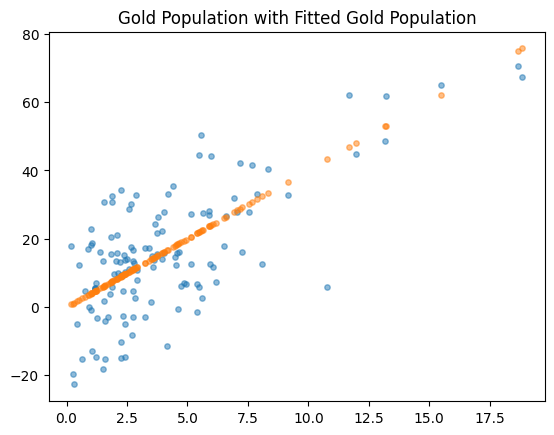

In [12]:
# Visualize

test(config)

As we can see, the model fits reasonably well. The following is a graph that shows the Widths generated by various other methods.

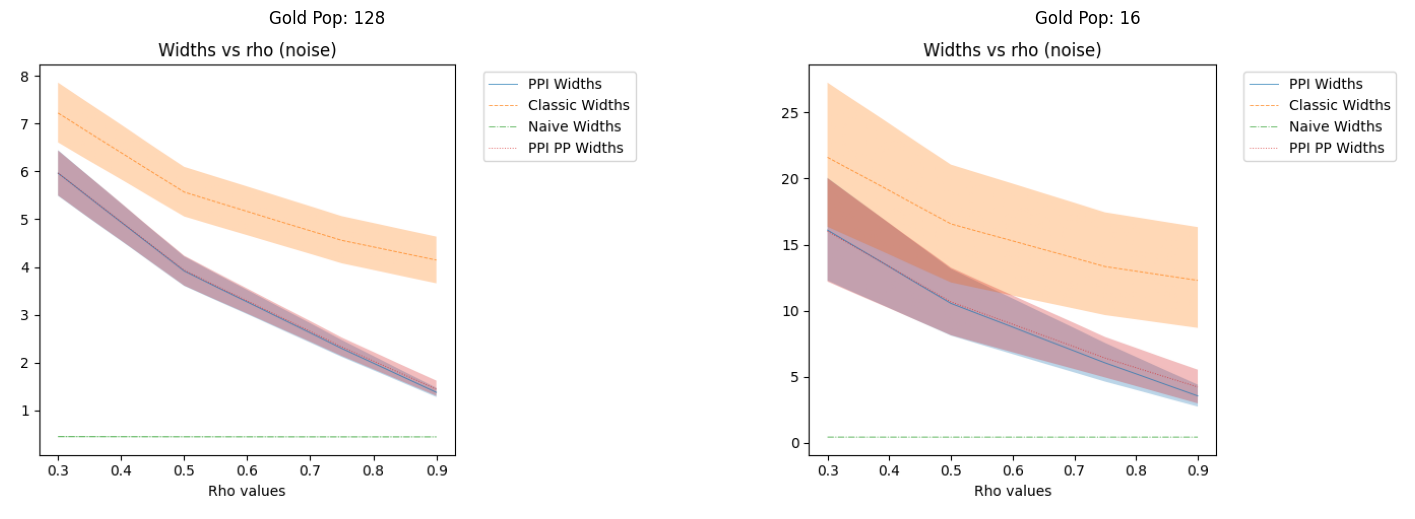

In [4]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_128 = '../experiments/Experiment_1/reg_lin_128_2024-07-30-00-07-14/plots/widthsplot.png'
gold_16 = '../experiments/Experiment_1/reg_lin_16_2024-07-30-00-06-38/plots/widthsplot.png'

# Display the PNG file
img_128 = plt.imread(gold_128)
img_16 = plt.imread(gold_16)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_128)
ax[0].axis('off')
ax[0].set_title('Gold Pop: 128')
ax[1].imshow(img_16)
ax[1].axis('off')
ax[1].set_title('Gold Pop: 16')
# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


If you look carefully, "Naive Widths" performs very well, which refers to imputing the values and treating those values as true data, then constructing a confidence interval as usual.

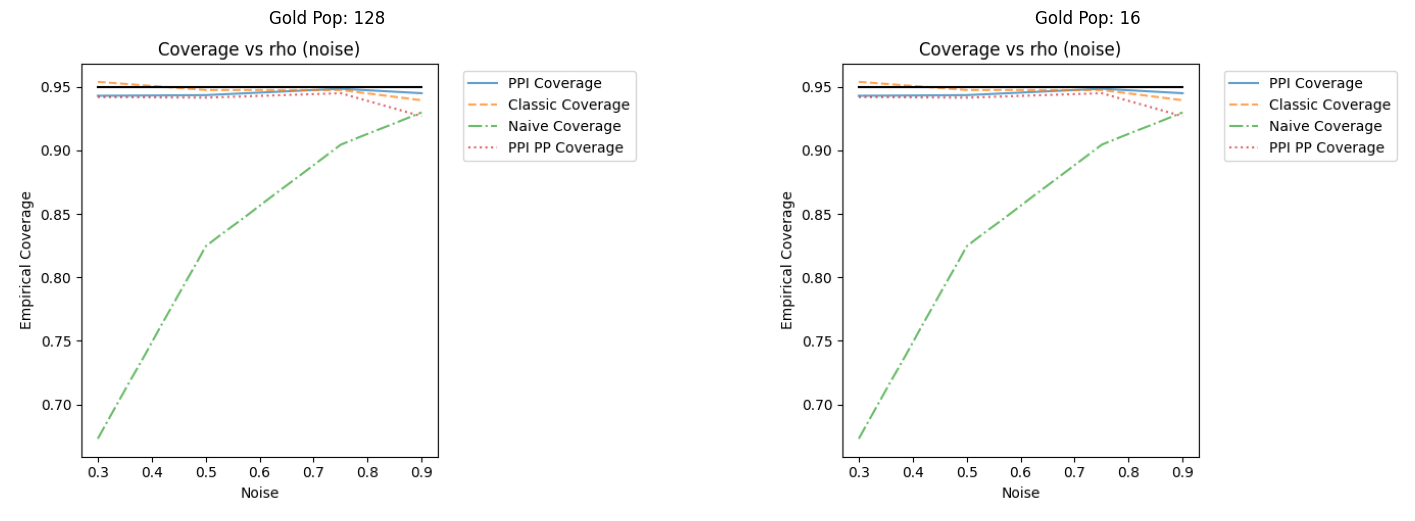

In [5]:
# Coverage plots

# Set the variable to the path of the PNG file
gold_128_cov = '../experiments/Experiment_1/reg_lin_128_2024-07-30-00-07-14/plots/coverageplot.png'
gold_16_cov = '../experiments/Experiment_1/reg_lin_16_2024-07-30-00-06-38/plots/coverageplot.png'

# Display the PNG file
img_128_cov = plt.imread(gold_128_cov)
img_16_cov = plt.imread(gold_128_cov)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_128_cov)
ax[0].axis('off')
ax[0].set_title('Gold Pop: 128')
ax[1].imshow(img_16_cov)
ax[1].axis('off')
ax[1].set_title('Gold Pop: 16')
# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

Unsurprisingly, since imputation gives biased results if the ML model is biased at all, and this method does not follow correct statistical assumptions, the confidence intervals generated, while small, don't often cover the true value.

### Setting 2

In this case, we change the distribution of $X \sim N(0, 4)$, however in this case, we set $Y = 3 * \sin (X) + \exp(X / 8) + \varepsilon$. Here $\varepsilon \sim N(0, \frac{\rho}{2})$. As such, the relationship is non symmetric, and highly non-linear. 

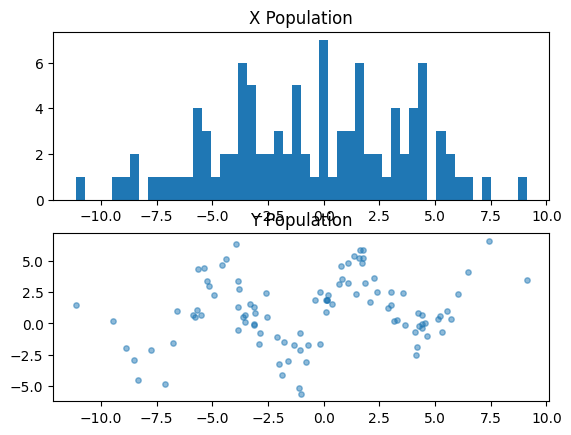

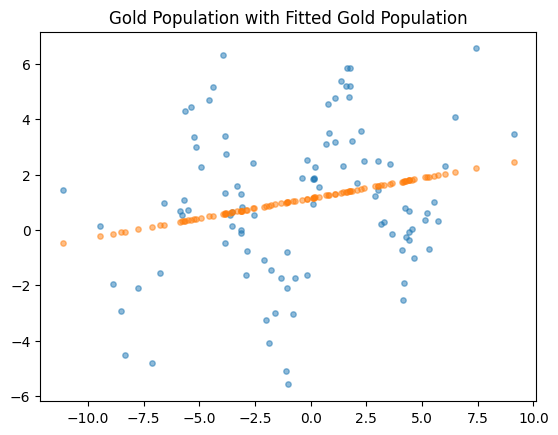

In [6]:
# Visualize setting 2

config2 = "../configs/Experiment_1_new/128g_nl_reg.yaml"
with open(config2, 'r') as stream:
    config2 = yaml.safe_load(stream)

def test2(config):
    rho_vals = [.7]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        pop_config['x_population']['size'] = 100
        x_gold, y_gold = dist.sample_population(pop_config)

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

test2(config2)

As we can see here, we do not expect PPI to have much benefit over classical methods.

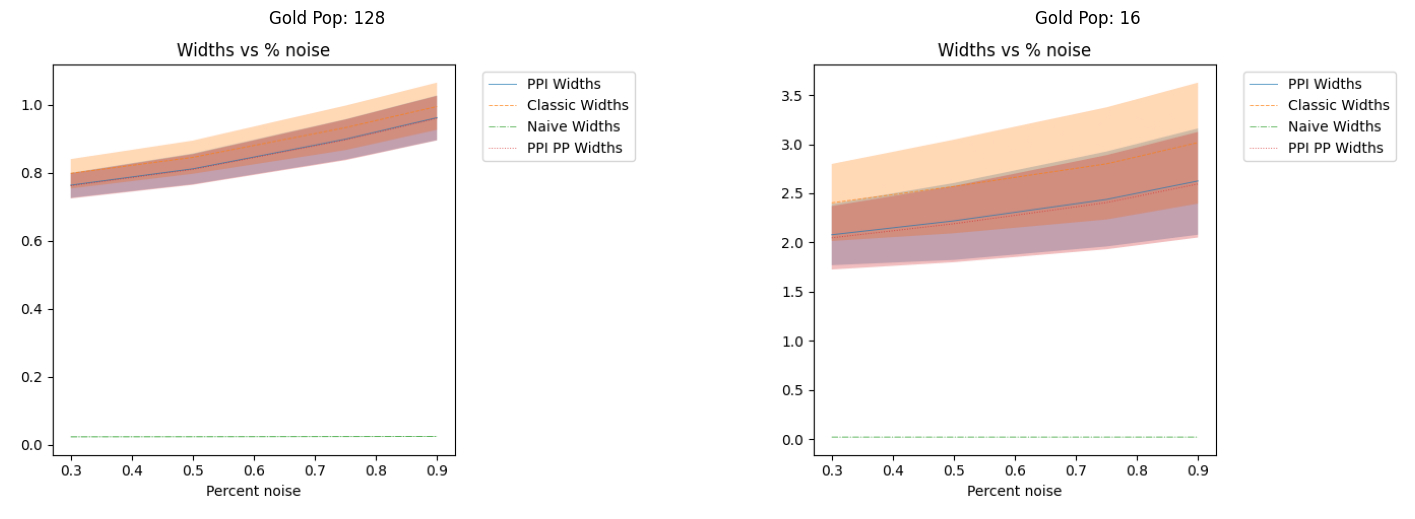

In [9]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_16_nl = '../experiments/16g_nl_reg_2024-08-13-02-42-06/plots/widthsplot.png'
gold_128_nl = '../experiments/128g_nl_reg_2024-08-13-02-42-48/plots/widthsplot.png'

# Display the PNG file
img_128_nl = plt.imread(gold_128_nl)
img_16_nl = plt.imread(gold_16_nl)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_128_nl)
ax[0].axis('off')
ax[0].set_title('Gold Pop: 128')
ax[1].imshow(img_16_nl)
ax[1].axis('off')
ax[1].set_title('Gold Pop: 16')
# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


Naturally then, one might one to replace our poorly fitted linear regression model, with another better function appoximator. In this case, we will use XGBoost. 

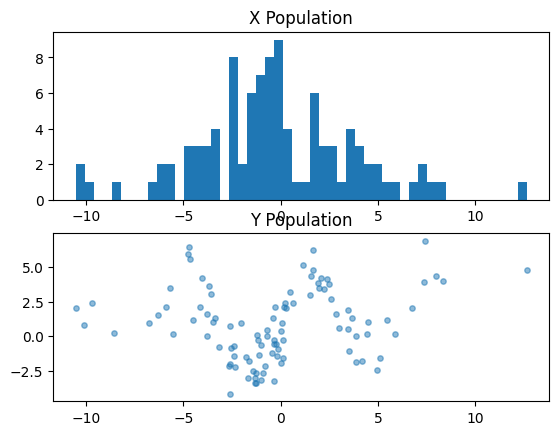

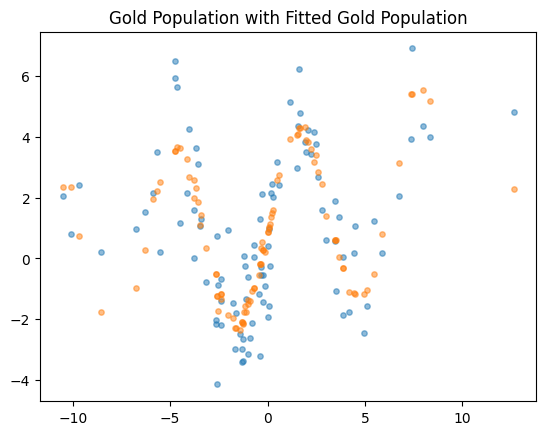

In [13]:
config3 = "../configs/Experiment_1_new/128g_nl_xgb.yaml"
with open(config3, 'r') as stream:
    config3 = yaml.safe_load(stream)

test2(config3)

From our visualization, XGBoost fits the data quite well. We would then expect PPI to perform well and give a significant reduction in width size.